# **Capstone project: Providing data-driven suggestions for HR**

- The stakeholder is the HR department at Salifort Motors.
- The task is to create a predictive model and use it to assist the department in identifying employees in risk of leaving the company.
- The dataset contains observations relevant to the task.
- There's no information in the dataset for observations that represent different groups in the workplace. 

### Import packages

In [71]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from xgboost import XGBClassifier

from xgboost import plot_importance

### Load dataset

In [44]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (Initial EDA and data cleaning)

### Gather basic information about the data

In [45]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [46]:
# Gather descriptive statistics about the data
df0.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


### Rename columns

As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [47]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [48]:
# Rename columns as needed
df0.rename(columns = {'satisfaction_level': 'satisfaction',
                      'number_project': 'projects',
                      'average_montly_hours': 'avg_monthly_hours',
                      'time_spend_company': 'tenure',
                      'Work_accident': 'accidents',
                      'left': 'churn',
                      'promotion_last_5years': 'promoted',
                      'Department': 'department',
                      'salary': 'compensation'}, inplace = True)

# Display all column names after the update
df0.columns

Index(['satisfaction', 'last_evaluation', 'projects', 'avg_monthly_hours',
       'tenure', 'accidents', 'churn', 'promoted', 'department',
       'compensation'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [49]:
# Check for missing values
df0.isna().sum()

satisfaction         0
last_evaluation      0
projects             0
avg_monthly_hours    0
tenure               0
accidents            0
churn                0
promoted             0
department           0
compensation         0
dtype: int64

### Check for duplicates

In [50]:
# Check for duplicates
dp_mask = df0.duplicated()
dp_mask

0        False
1        False
2        False
3        False
4        False
         ...  
14994     True
14995     True
14996     True
14997     True
14998     True
Length: 14999, dtype: bool

In [51]:
# Inspect some rows containing duplicates as needed
df0[dp_mask]

,satisfaction,last_evaluation,projects,avg_monthly_hours,tenure,accidents,churn,promoted,department,compensation
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


### Check for outliers

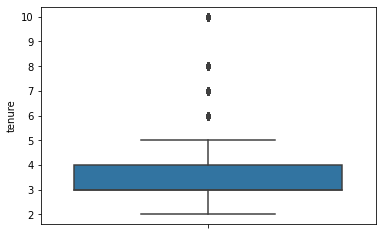

In [53]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(y = df0['tenure'])


In [54]:
# Determine the number of rows containing outliers
percentile_25 = df0['tenure'].quantile(0.25)
percentile_75 = df0['tenure'].quantile(0.75)
iqr = percentile_75 - percentile_25

upper_limit = percentile_75 + 1.5 * iqr

df0[df0['tenure'] > upper_limit]

,satisfaction,last_evaluation,projects,avg_monthly_hours,tenure,accidents,churn,promoted,department,compensation
1,0.80,0.86,5,262,6,0,1,0,sales,medium
17,0.78,0.99,4,255,6,0,1,0,sales,low
34,0.84,0.87,4,246,6,0,1,0,hr,low
47,0.57,0.70,3,273,6,0,1,0,support,low
67,0.90,0.98,4,264,6,0,1,0,product_mng,medium
...,...,...,...,...,...,...,...,...,...,...
14942,0.20,0.50,5,135,6,0,1,0,RandD,low
14947,0.91,0.98,4,242,6,0,1,0,support,low
14977,0.81,0.85,4,251,6,0,1,0,hr,medium
14986,0.85,0.85,4,247,6,0,1,0,technical,low


## Step 2. Data Exploration (Continue EDA)

In [55]:
# Get numbers of people who left vs. stayed
left = df0[df0['churn'] == 1].count()[0]
stayed = df0[df0['churn'] == 0].count()[0]

print("Employees left: {:>6}".format(left))
print("Employees stayed: {}".format(stayed))

# Get percentages of people who left vs. stayed
print("Employees left: {:>4.0f}%".format((left/df0.shape[0])*100))
print("Employees stayed: {:.0f}%".format((stayed/df0.shape[0])*100))

Employees left:   3571
Employees stayed: 11428
Employees left:   24%
Employees stayed: 76%


### Data visualizations

[(0.0, 1.0)]

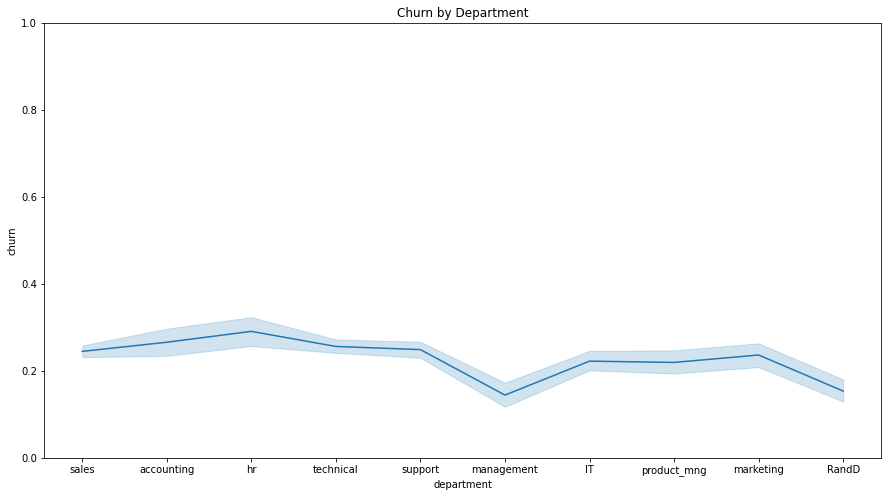

In [56]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['department'], y = df0['churn'])
v.set_title('Churn by Department')
v.set(ylim=(0, max(df0['churn'])))

[(0.0, 1.0)]

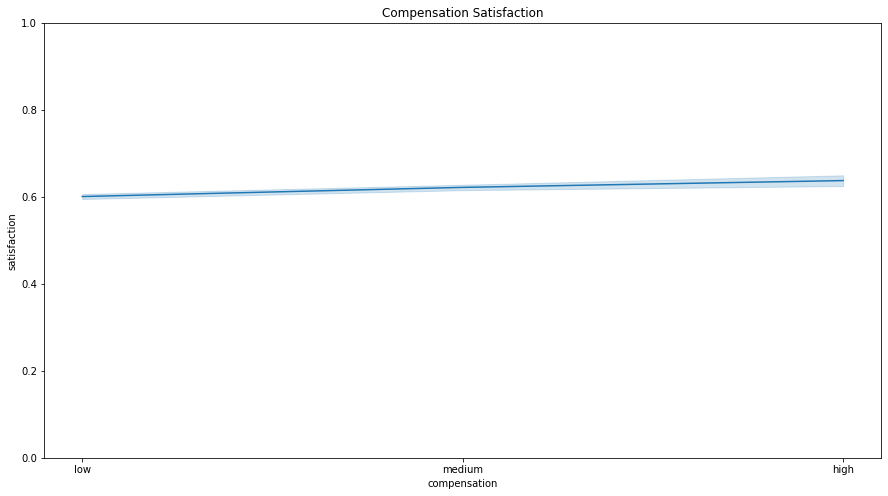

In [57]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['compensation'], y = df0['satisfaction'])
v.set_title('Compensation Satisfaction')
v.set(ylim=(0, max(df0['satisfaction'])))

[(0.0, 1.0)]

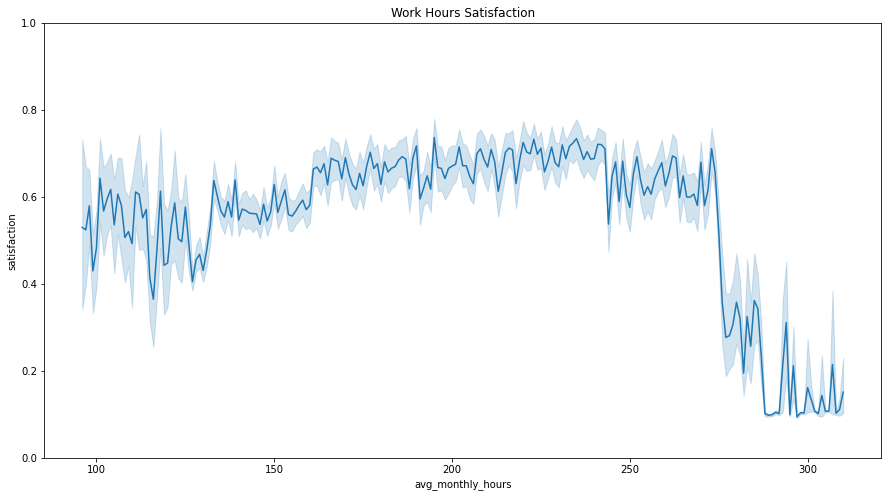

In [58]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['avg_monthly_hours'], y = df0['satisfaction'])
v.set_title('Work Hours Satisfaction')
v.set(ylim=(0, max(df0['satisfaction'])))

[(0.0, 1.0)]

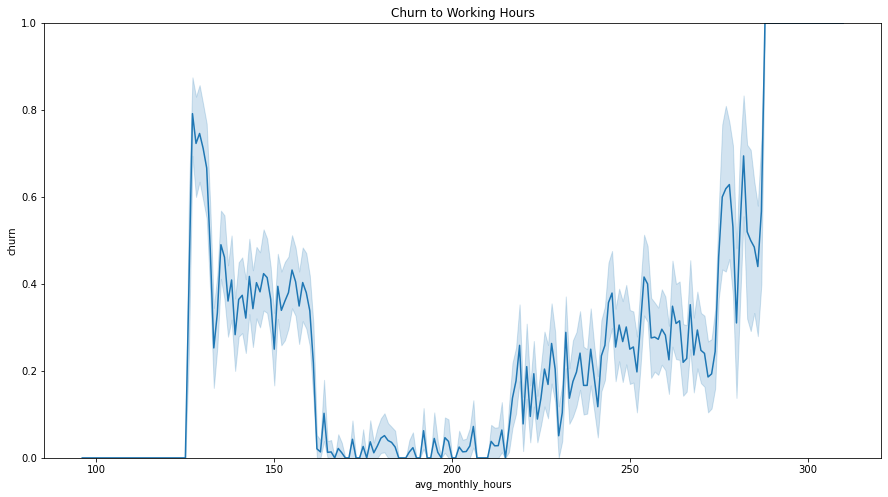

In [59]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['avg_monthly_hours'], y = df0['churn'])
v.set_title('Churn to Working Hours')
v.set(ylim=(0, max(df0['churn'])))

[(0.0, 310.0)]

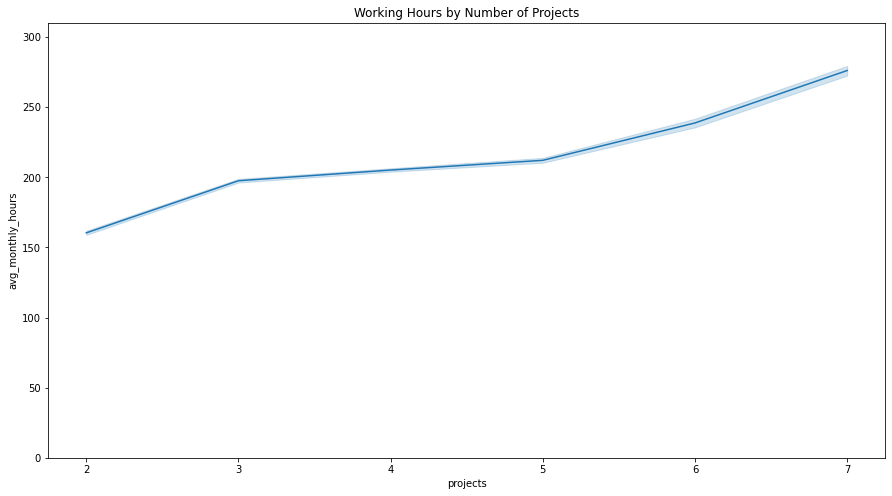

In [70]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['projects'], y = df0['avg_monthly_hours'])
v.set_title('Working Hours by Number of Projects')
v.set(ylim=(0, max(df0['avg_monthly_hours'])))

[(0.0, 1.0)]

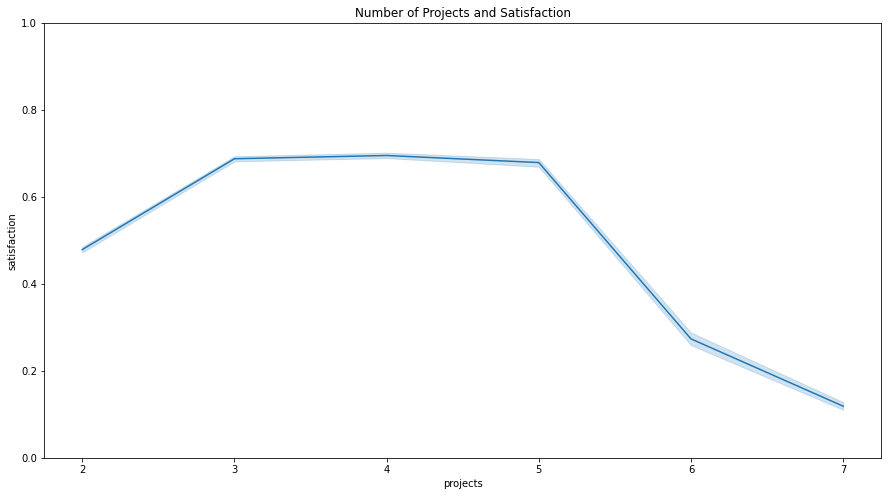

In [62]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['projects'], y = df0['satisfaction'])
v.set_title('Number of Projects and Satisfaction')
v.set(ylim=(0, max(df0['satisfaction'])))

[(0.0, 1.0)]

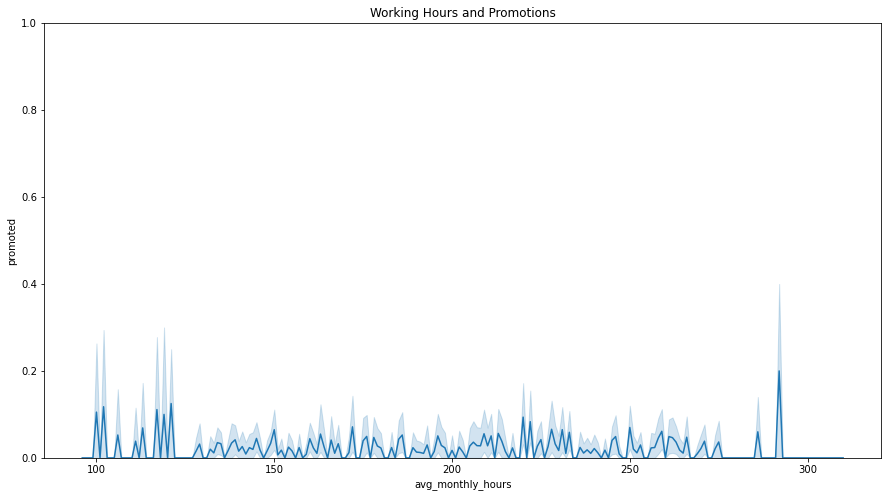

In [60]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['avg_monthly_hours'], y = df0['promoted'])
v.set_title('Working Hours and Promotions')
v.set(ylim=(0, max(df0['promoted'])))

[(0.0, 1.0)]

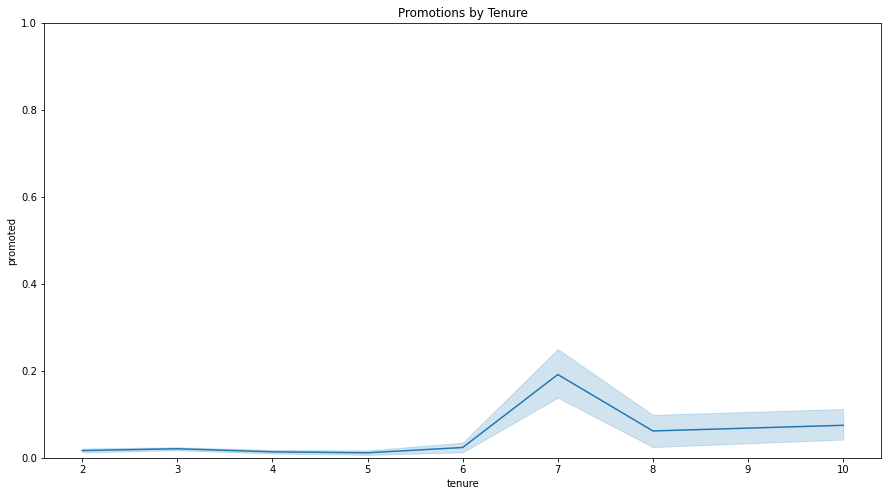

In [67]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['tenure'], y = df0['promoted'])
v.set_title('Promotions by Tenure')
v.set(ylim=(0, max(df0['promoted'])))

[(0.0, 10.0)]

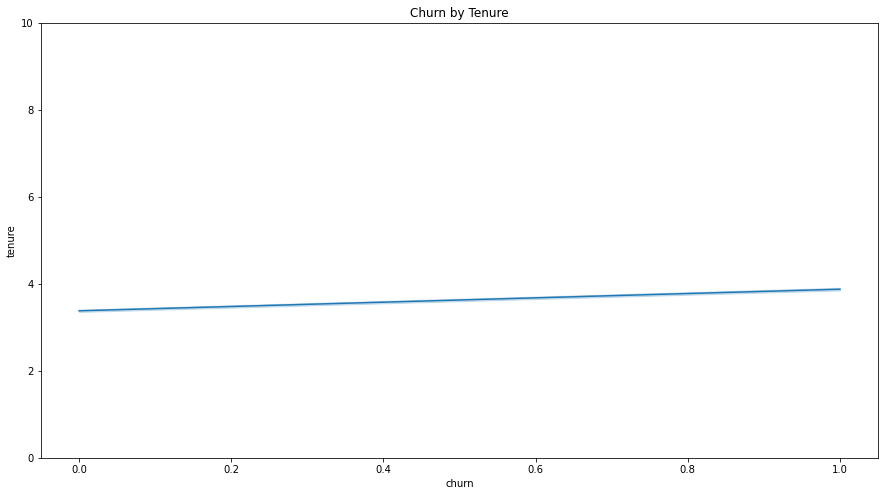

In [74]:
# Create a plot as needed
plt.figure(figsize=(15,8))
v = sns.lineplot(x = df0['churn'], y = df0['tenure'])
v.set_title('Churn by Tenure')
v.set(ylim=(0, max(df0['tenure'])))

### Insights

- There's strong correlation between average work hours, number of projects, satisfaction and churn.

## Step 3. Model Building, Step 4. Results and Evaluation

### Modeling

In [76]:
# Selecting features
df = df0.drop(['compensation', 'department', 'accidents', 'last_evaluation'], axis=1)
df.head(5)

,satisfaction,projects,avg_monthly_hours,tenure,churn,promoted
0,0.38,2,157,3,1,0
1,0.80,5,262,6,1,0
2,0.11,7,272,4,1,0
3,0.72,5,223,5,1,0
4,0.37,2,159,3,1,0


In [102]:
# Splitting data
y = df['churn']
X = df.drop(columns=['churn'])

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

In [115]:
# XGBoost Model construction
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }
scoring = {'accuracy', 'precision', 'recall', 'f1'}
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [116]:
# Fitting the data
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     predictor=None, random_state=42,
                                     reg_alpha=None, ...),
             iid='deprecate

In [117]:
# Best score
xgb_cv.best_score_

0.9408019426676142

In [118]:
# Best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

In [123]:
# Model validation
xgb_val_prediction = xgb_cv.best_estimator_.predict(X_val)
xgb_val_prediction

array([0, 0, 1, ..., 0, 1, 0])

In [120]:
# Scores helper function
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [125]:
# Evaluate model scores
xgb_scores = get_test_scores('XGB val', xgb_val_prediction, y_val)
xgb_scores

,model,precision,recall,F1,accuracy
0,XGB val,0.973554,0.9424,0.957724,0.98019


In [130]:
# Test data predictions
xgb_test_prediction = xgb_cv.best_estimator_.predict(X_test)
xgb_test_scores = get_test_scores('XGB test', xgb_test_prediction, y_test)
xgb_test_scores

,model,precision,recall,F1,accuracy
0,XGB test,0.976879,0.946779,0.961593,0.982


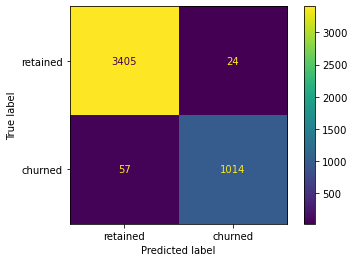

In [128]:
# Confusion matrix
cm = confusion_matrix(y_test, xgb_test_prediction, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot(values_format='')

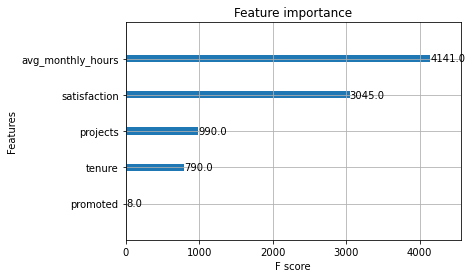

In [131]:
plot_importance(xgb_cv.best_estimator_)

### Summary of model results

- Using the provided observations, a model with accuracy of 96% was constructed.
- The model shows minimal False Positive and False Negative results.

### Conclusion, Recommendations, Next Steps

- With high confidence, one of the most important contributors to churn for the company is "working hours" and "number of projects".
- This indicates that workload is distributed in an unfavorable way, with strong correlation between identified contributors and churn increase.
- Salifort Motors can take steps to remedy the issue by distributing tasks in an advantageous way.